hello there, here we are going to creat a cnn to classify Sign Language.
![/kaggle/input/sign-language-mnist/amer_sign2.png](http://)

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import csv
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import matplotlib.pyplot as plt
from keras.optimizers import Adam

2024-02-06 10:38:33.370006: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 10:38:33.370143: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-06 10:38:33.533495: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_data = pd.read_csv('/kaggle/input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv')
test_data  = pd.read_csv('/kaggle/input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv')

In [3]:
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [4]:
print("number of classes:", len(train_data['label'].unique()))

number of classes: 24


if we take a look at the data we will notice that the lables are saved in the first column, so we have to seperate them.

In [5]:
X_train = train_data.copy()
X_test  = test_data.copy()
y_train = X_train.pop('label')
y_test  =  X_test.pop('label')

In [6]:
print('X train shape :', X_train.shape)
print('train label shape:', y_train.shape)
print('X test shsape:', X_test.shape)
print('test label shape', y_test.shape)


X train shape : (27455, 784)
train label shape: (27455,)
X test shsape: (7172, 784)
test label shape (7172,)


let's see how many samples we have from each sign.

<Axes: xlabel='label'>

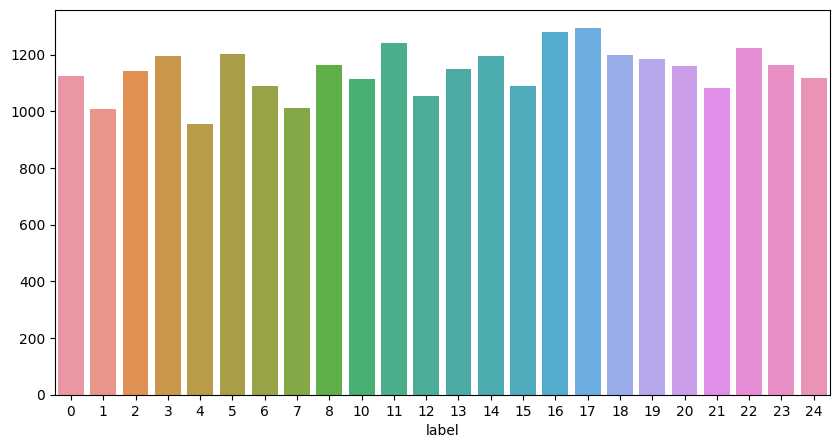

In [7]:
plt.figure(figsize=(10,5))
sns.barplot(x=y_train.value_counts().index, y=y_train.value_counts().values)

it's fairly balanced data.

we should reshape our data to look like standard images
(28*28)

In [8]:
X_train = X_train.values.reshape(-1, 28, 28, 1)
X_test  = X_test.values.reshape(-1, 28, 28, 1)

In [9]:
X_train.shape

(27455, 28, 28, 1)

let's visualize some samples!

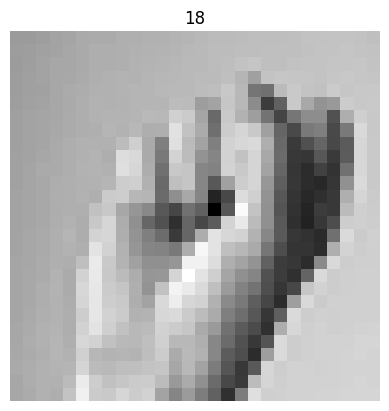

In [10]:
#you can change image_number to see different images.(between 0 and 27454)
image_number = 27000
img = X_train[image_number, :, :]
img = img.reshape((28,28))
plt.imshow(img,cmap='gray')
plt.title( y_train[image_number])
plt.axis("off")
plt.show()

normalizing images and encoding labels.

In [11]:
X_train = X_train / 255.0
X_test  = X_test / 255.0
X_train = X_train.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)

In [12]:
from keras.utils import to_categorical # convert to one-hot-encoding
y_train = to_categorical(y_train, num_classes = 25)
y_test  = to_categorical(y_test,  num_classes = 25)

**defining the model.**

In [13]:

from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense

model = tf.keras.models.Sequential([
    Conv2D(16, (3,3), activation = 'relu', input_shape=(28, 28, 1)),
    MaxPooling2D(2,2),
           
    Conv2D(32, (3,3), activation = 'relu'),
    MaxPooling2D(2,2),
           
    Conv2D(64, (3,3), activation = 'relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(25,  activation = 'softmax')])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 1, 1, 64)          0

In [15]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

Data Augmentation

In [16]:
datagen = ImageDataGenerator(
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1)  # randomly shift images vertically 10%
    
datagen.fit(X_train)

In [17]:
# Fit the model
epochs = 20
batch_size = 250
history = model.fit(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_test,y_test), steps_per_epoch=X_train.shape[0] // batch_size)

Epoch 1/20
109/109 [==============================] - 14s 118ms/step - loss: 2.9554 - accuracy: 0.1219 - val_loss: 2.5192 - val_accuracy: 0.2057
Epoch 2/20
109/109 [==============================] - 13s 119ms/step - loss: 2.1988 - accuracy: 0.3112 - val_loss: 1.8329 - val_accuracy: 0.3954
Epoch 3/20
109/109 [==============================] - 13s 119ms/step - loss: 1.7648 - accuracy: 0.4441 - val_loss: 1.3902 - val_accuracy: 0.5561
Epoch 4/20
109/109 [==============================] - 13s 115ms/step - loss: 1.4484 - accuracy: 0.5371 - val_loss: 1.1755 - val_accuracy: 0.6008
Epoch 5/20
109/109 [==============================] - 13s 115ms/step - loss: 1.2306 - accuracy: 0.5992 - val_loss: 1.0264 - val_accuracy: 0.6378
Epoch 6/20
109/109 [==============================] - 12s 113ms/step - loss: 1.0539 - accuracy: 0.6549 - val_loss: 0.8448 - val_accuracy: 0.6810
Epoch 7/20
109/109 [==============================] - 12s 114ms/step - loss: 0.9285 - accuracy: 0.6943 - val_loss: 0.8047 - val_ac

In [18]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

/tmp/ipykernel_19/201344455.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


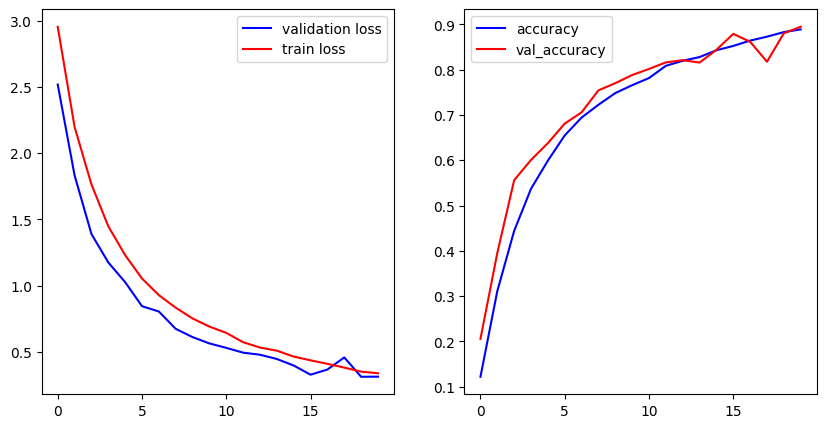

In [19]:
plt.subplots(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.plot(history.history['loss'], color='r', label="train loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], color='b', label="accuracy")
plt.plot(history.history['val_accuracy'], color='r', label="val_accuracy")
plt.legend()

seems it's getting better and better and we don't have any obvious overfitting, so let's train another 10 epochs:

In [20]:
history2 = model.fit(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = 10, validation_data = (X_test,y_test), steps_per_epoch=X_train.shape[0] // batch_size)

Epoch 1/10
109/109 [==============================] - 13s 117ms/step - loss: 0.3227 - accuracy: 0.8917 - val_loss: 0.3203 - val_accuracy: 0.8861
Epoch 2/10
109/109 [==============================] - 12s 110ms/step - loss: 0.3032 - accuracy: 0.8995 - val_loss: 0.2862 - val_accuracy: 0.8926
Epoch 3/10
109/109 [==============================] - 12s 113ms/step - loss: 0.2887 - accuracy: 0.9047 - val_loss: 0.2847 - val_accuracy: 0.8997
Epoch 4/10
109/109 [==============================] - 12s 113ms/step - loss: 0.2670 - accuracy: 0.9142 - val_loss: 0.2459 - val_accuracy: 0.9198
Epoch 5/10
109/109 [==============================] - 13s 117ms/step - loss: 0.2511 - accuracy: 0.9152 - val_loss: 0.2269 - val_accuracy: 0.9163
Epoch 6/10
109/109 [==============================] - 13s 116ms/step - loss: 0.2369 - accuracy: 0.9208 - val_loss: 0.2298 - val_accuracy: 0.9127
Epoch 7/10
109/109 [==============================] - 12s 112ms/step - loss: 0.2241 - accuracy: 0.9253 - val_loss: 0.2552 - val_ac

/tmp/ipykernel_19/200541517.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


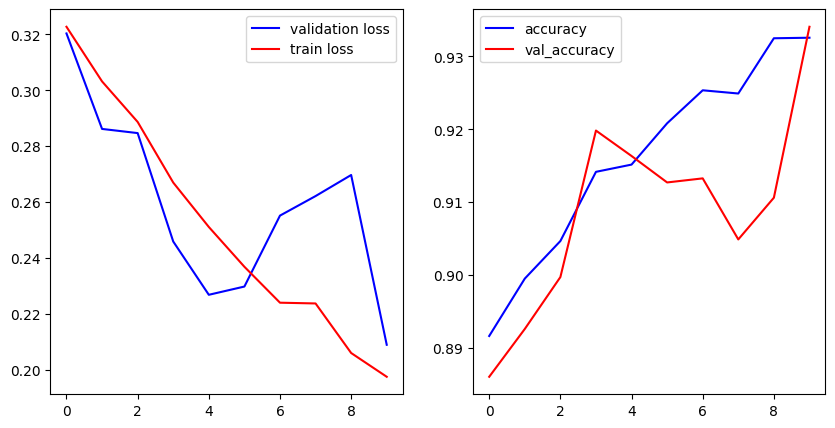

In [21]:
plt.subplots(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history2.history['val_loss'], color='b', label="validation loss")
plt.plot(history2.history['loss'], color='r', label="train loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history2.history['accuracy'], color='b', label="accuracy")
plt.plot(history2.history['val_accuracy'], color='r', label="val_accuracy")
plt.legend()

still no problem, so let's give it another try!

In [22]:
history3 = model.fit(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = 10, validation_data = (X_test,y_test), steps_per_epoch=X_train.shape[0] // batch_size)

Epoch 1/10
109/109 [==============================] - 13s 118ms/step - loss: 0.1906 - accuracy: 0.9358 - val_loss: 0.2036 - val_accuracy: 0.9322
Epoch 2/10
109/109 [==============================] - 12s 112ms/step - loss: 0.1828 - accuracy: 0.9387 - val_loss: 0.2028 - val_accuracy: 0.9380
Epoch 3/10
109/109 [==============================] - 13s 119ms/step - loss: 0.1769 - accuracy: 0.9412 - val_loss: 0.1945 - val_accuracy: 0.9446
Epoch 4/10
109/109 [==============================] - 12s 112ms/step - loss: 0.1726 - accuracy: 0.9436 - val_loss: 0.2212 - val_accuracy: 0.9301
Epoch 5/10
109/109 [==============================] - 13s 116ms/step - loss: 0.1602 - accuracy: 0.9459 - val_loss: 0.1953 - val_accuracy: 0.9392
Epoch 6/10
109/109 [==============================] - 13s 114ms/step - loss: 0.1598 - accuracy: 0.9481 - val_loss: 0.2049 - val_accuracy: 0.9268
Epoch 7/10
109/109 [==============================] - 13s 116ms/step - loss: 0.1514 - accuracy: 0.9503 - val_loss: 0.1830 - val_ac

/tmp/ipykernel_19/722619831.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


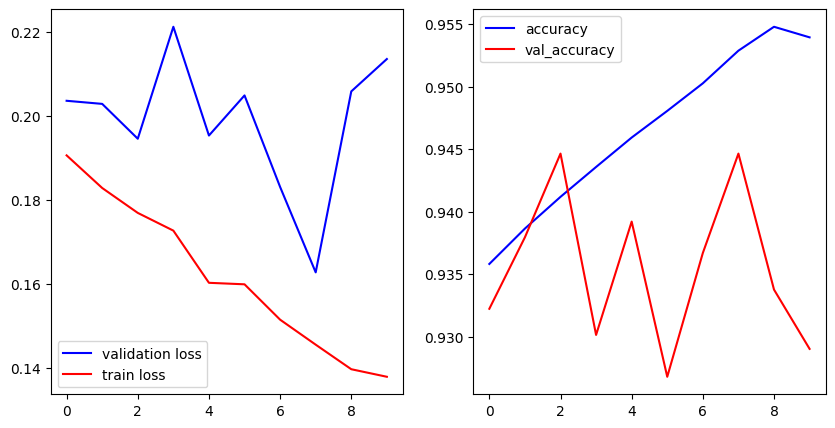

In [23]:
plt.subplots(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history3.history['val_loss'], color='b', label="validation loss")
plt.plot(history3.history['loss'], color='r', label="train loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history3.history['accuracy'], color='b', label="accuracy")
plt.plot(history3.history['val_accuracy'], color='r', label="val_accuracy")
plt.legend()

strangely our net has always been working better on test than training(maybe it's because our test set is easier to classify, so it's better next time mix them and shuffle), but anyway we got a good result here and it could have performed even better  if we'd let it train longer. although we didn't use any regularization algorithm(like l2 or dropout) but our net didn't show any overfitting problem.


In [24]:
overal_history = {}
for k in history.history.keys():
    overal_history[k] = history.history[k] + history2.history[k] + history3.history[k]

/tmp/ipykernel_19/3494871323.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


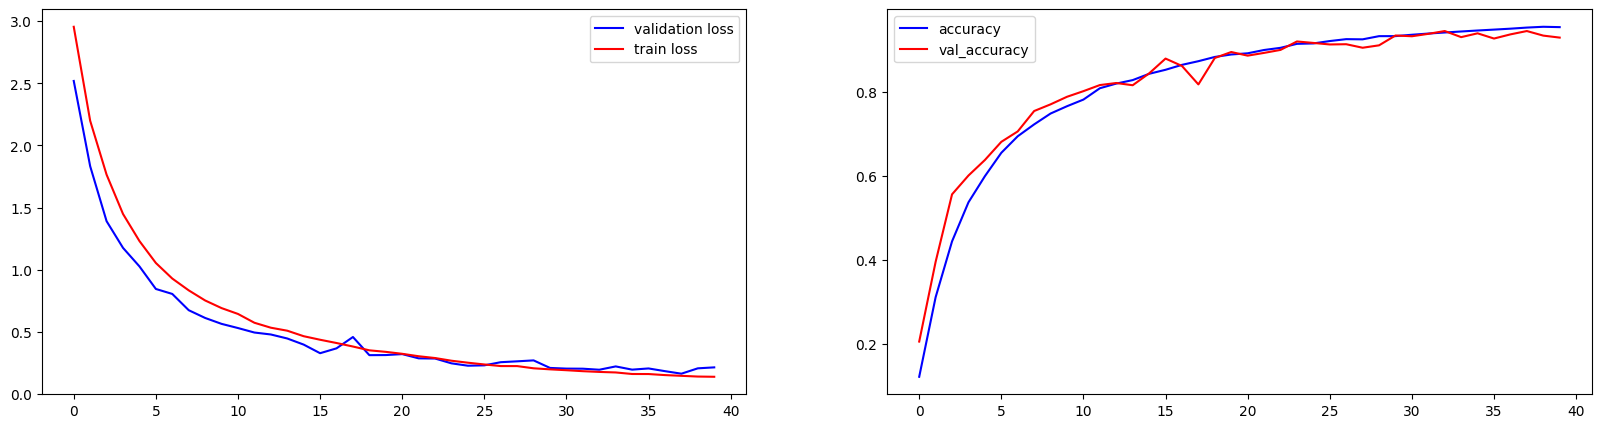

In [25]:
plt.subplots(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(overal_history['val_loss'], color='b', label="validation loss")
plt.plot(overal_history['loss'], color='r', label="train loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(overal_history['accuracy'], color='b', label="accuracy")
plt.plot(overal_history['val_accuracy'], color='r', label="val_accuracy")
plt.legend()